# Synthetic Data Generation + Usage Example

In [2]:
import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import evaluation.eval_framework as evu
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [22]:
import importlib

importlib.reload(evu)

<module 'evaluation.eval_framework' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/eval_framework.py'>

## Step 1: Generate a year of data
- two random dates chosen per week
- Max date is yesterday
- duplicate dates removed

In [3]:
dates_2023 = evu.generate_random_dates(2023)
dates_2024 = evu.generate_random_dates(2024)
distinct_date_list = dates_2023 + dates_2024

## Step 2: Set keyword parameters + generate dataframe

### Example: At home EV charging

- Covers a 5.5 - 8.5 hour variable length window
- The vehicle has a BMW and has an average power draw of 42.5
- Battery is usually typically 50% charged at plug in time.
- Charging occurs during the workday

In [11]:
ev_kwargs = {
    "power_output_max_rates": [42.5], # BMW average
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "average_battery_starting_capacity": 0.5,  # average starting percent charged
    "start_hour": "09:00:00",  # earliest session can start
    "end_hour": "17:00:00",  # latest session can start
}

### Example: AI Model Training

- Model training can occur at any time of day
- There are 3 server models that consume 240, 310, and 400 watt-hour on average
- Early stopping is not an option

In [12]:
# criteria
ai_kwargs = {
    "power_output_max_rates": [240,310,400], # assuming a bare metal usecase, k8s or vm rescale to vCPU
    "start_hour": "00:00:00",  # earliest session can start
    "end_hour": "23:59:00",  # latest session can start
    "user_charge_tolerance":1.0 # job must run to completion
}

## Step 3: Generate dataframe for x # of synthetic users
- synthetic user = user behavior + device characteristics

In [13]:
# generating data for 1 vehicle
df_ev = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=1, **ev_kwargs
)

100%|██████████| 1/1 [00:00<00:00, 44.53it/s]


In [14]:
# generating data for 1 vehicle
df_ev = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=1, **ev_kwargs
)

# generating data for 5 AI models
df_ai = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=5, **ai_kwargs
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 48.95it/s]


## Synth Data Distributions

Text(0.5, 1.0, 'EV Synthetic Data - Charging Session Length (seconds)')

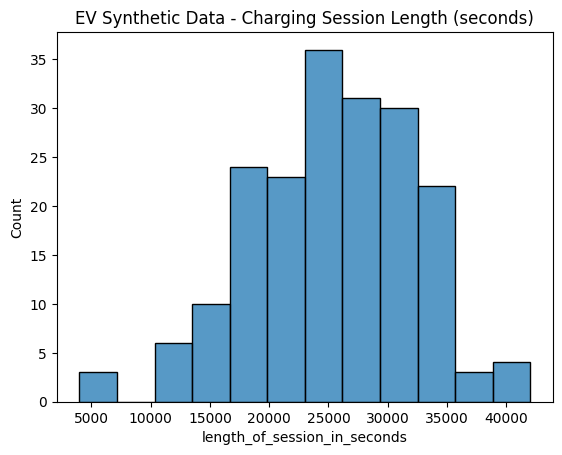

In [15]:
sns.histplot(df_ev["length_of_session_in_seconds"]).set_title(
    "EV Synthetic Data - Charging Session Length (seconds)"
)

Text(0.5, 1.0, 'AI Synthetic Data - Training Session Length (seconds)')

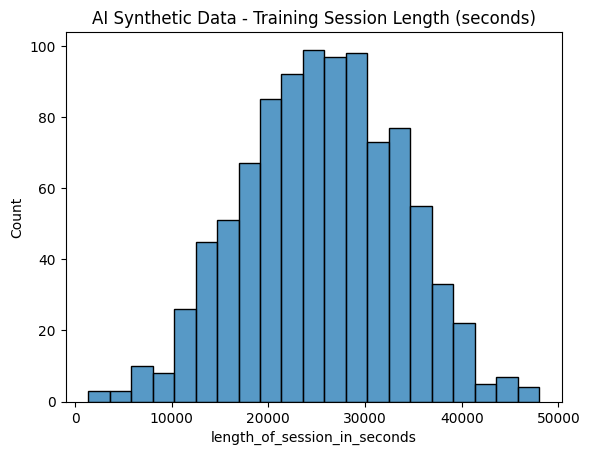

In [16]:
sns.histplot(df_ai["length_of_session_in_seconds"]).set_title(
    "AI Synthetic Data - Training Session Length (seconds)"
)

## Step 3: Get MOER forecast and actuals

In [17]:
# taking a subset of data - this takes a while to run
synth_data = df_ai.sample(2)
region = "SPP_SIOUX"

In [18]:
synth_data["moer_forecast"] = synth_data.apply(  # 14 seconds
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, 
        math.ceil(x.total_intervals_plugged_in), 
        region=region
    ),
    axis=1,
)

synth_data["moer_actual"] = synth_data.apply(  # 11 sec
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

## Step 4: Optimize

- For this use case we can use the simplest optimizer give that we have no additional constraints

In [23]:
def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

synth_data["optimizer_ideal"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed= sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds),
        total_time_horizon=sanitize_total_intervals(x.total_intervals_plugged_in),
        moer_data=x.moer_actual,
        optimization_method="simple",
    ),
    axis=1,
)

synth_data["ideal_charging_schedule"] = synth_data[
    "optimizer_ideal"
].apply(get_charging_schedule_lambda)

synth_data["ideal_emissions"] = synth_data["optimizer_ideal"].apply(
    get_total_emissions_lambda
)

== Simple fit! ==
== Simple fit! ==


In [26]:
synth_data["optimizer_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed= sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds),
        total_time_horizon=sanitize_total_intervals(x.total_intervals_plugged_in),
        moer_data=x.moer_forecast,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["charging_schedule"] = synth_data[
    "optimizer_simple"
].apply(get_charging_schedule_lambda)

synth_data["forecast_emissions"] = synth_data["optimizer_simple"].apply(
    get_total_emissions_lambda
)

synth_data["actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_actual["value"],
        x.optimizer_simple.energy_usage_mwh,
    ),
    axis=1,
)

== Simple fit! ==
== Simple fit! ==


In [29]:
synth_data["optimizer_baseline"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.power_output_rate,
        time_needed= sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds),
        total_time_horizon=sanitize_total_intervals(x.total_intervals_plugged_in),
        moer_data=x.moer_actual,
        optimization_method="baseline",
    ),
    axis=1,
)

synth_data["charging_schedule"] = synth_data[
    "optimizer_baseline"
].apply(get_charging_schedule_lambda)

synth_data["baseline_emissions"] = synth_data["optimizer_baseline"].apply(
    get_total_emissions_lambda
)

== Baseline fit! ==
== Baseline fit! ==


## Step 5: Results

In [57]:
importlib.reload(m)

<module 'evaluation.metrics' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/metrics.py'>

In [58]:
em = m.EvalMetrics(
    baseline_col= "baseline_emissions",
    ideal_col="ideal_emissions", 
    forecast_col="forecast_emissions",
    actuals_col="actual_emissions"
    )

In [59]:
em.calculate_results(synth_data,percent=True)

,emissions_avoided_percent,baseline_difference_percent,ideal_difference_percent,actuals_difference_percent
0,0.012782,-0.089607,-0.070633,-0.077970
1,0.432836,2.221875,10.896154,3.616418


In [60]:
em.calculate_results(synth_data)

,emissions_avoided,baseline_difference,ideal_difference,actuals_difference
0,0.812600,-5.769460,-4.454960,-4.956860
1,0.609072,4.479833,5.950008,5.088906


## Generate an optional variable power curve

In [21]:
from evaluation.config import CARS
import evaluation.battery as b

In [25]:
synth_data["variable_power_output_rate"] = synth_data.apply( 
    lambda x: b.Battery(
        initial_soc = x.initial_charge, 
        charging_curve = bmw_charging_curve,
        capacity_kWh = x.total_capacity
    ).get_usage_power_kw_df(),
    axis=1
    )

In [25]:
time_needed = evu.get_time_needed(
    total_capacity_kWh=b.capacity_kWh,
    usage_power_kW=b.get_usage_power_kw_df(),
    initial_capacity_fraction=b.initial_soc,
)

AttributeError: module 'evaluation.battery' has no attribute 'capacity_kWh'